# Motion Recognition

In this notebook, we will explore data collected from an accelerometer to predict the class of the motion that was registered.

#### Library Imports

In [1]:
import os
import glob
import shutil

In [75]:
import numpy as np
import pandas as pd

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn import metrics

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
sns.set_theme(style="darkgrid", palette='Set2')

### Importing Data

Our data is a collection of observations, in four possible categories: Idle, Running, Stairs and Walking. Each observation lasts for 30 units of time (steps) and registers the Linear Acceleration in X,Y,Z in $m/s^2$.

In [6]:
folders = ['idle','running','stairs', 'walking']

for folder in folders:
    path = f"./data/{folder}"
    os.chdir(path)

    extension = 'csv'
    all_files = [file for file in glob.glob('*.{}'.format(extension))]
    df_list = []
    
    # Add columns
    for file in all_files:
        motion,record = file.split('.')[0].split('-')
        df = (pd.read_csv(file).assign(Motion=motion, Record=record))
        df['Step'] = df.index
        df_list.append(df)
        
    # Length file
    print(f'Nr records in {folder}: ' + str(len(df_list)))
    
    # Combine files
    combined_file = pd.concat(df_list)
    
    # Export to csv 
    combined_file.to_csv( f"combined_{folder}.csv", index=False, encoding='utf-8-sig')
    
    # Move file
    shutil.move(f"combined_{folder}.csv", f"../combined_{folder}.csv")
    
    # Return to main directory
    os.chdir("../../")

Nr records in idle: 1039
Nr records in running: 3408
Nr records in stairs: 165
Nr records in walking: 1850


We are working with imbalanced classes: there are only 165 records of stairs, 1039 in idle, 1850 in walking and 3408 in running.

### Exploratory Analysis

In [7]:
# Read data
path = "./data"
os.chdir(path)

idle = pd.read_csv("combined_idle.csv")
running = pd.read_csv("combined_running.csv")
stairs = pd.read_csv("combined_stairs.csv")
walking = pd.read_csv("combined_walking.csv")

In [49]:
# Pick Random Samples
idle_sample = idle[idle['Record']==300]
running_sample = running[running['Record']==1027]
stairs_sample = stairs[stairs['Record']==100]
walking_sample = walking[walking['Record']==1120]

Let us look at our data.

We will plot a random example of each class.

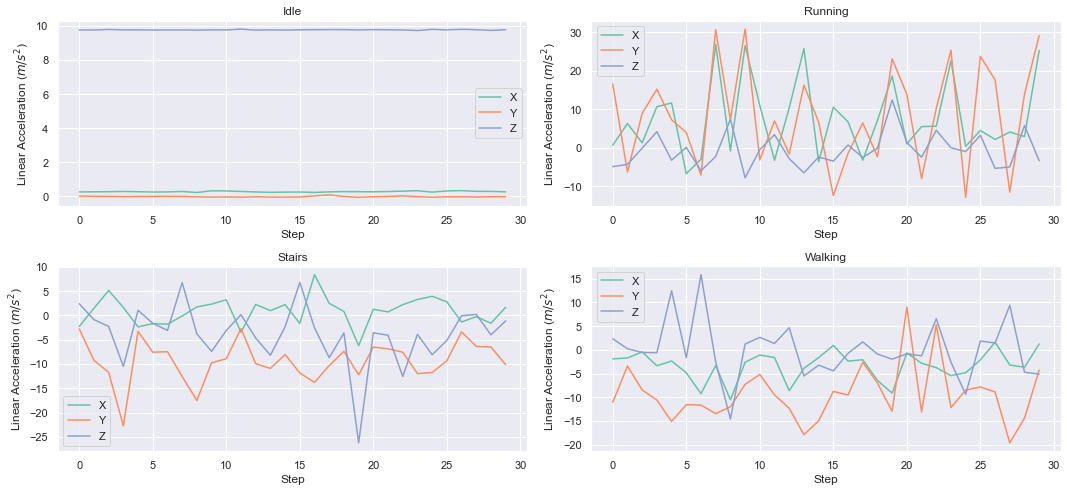

In [50]:
plt.rcParams['figure.figsize'] = (15,7)

samples = [idle_sample, running_sample, stairs_sample, walking_sample]
motions = ['Idle', 'Running', 'Stairs', 'Walking']
i = 1

for sample in samples: 
    plt.subplot(2, 2, i)
    
    for axis in ['X','Y','Z']:
        sns.lineplot(y=sample[f'accelerometer_{axis}'], x=sample['Step'], label=f'{axis}')

    plt.title(motions[i-1])
    plt.ylabel('Linear Acceleration ($m/s^2$)')
    plt.xlabel('Step')
    
    i+=1

plt.tight_layout()
plt.show()

There is a clear difference in the profile of Idle (which is constant) compared to the remaining classes.

In [56]:
# Mean value at X,Y,Z of each Record
df_avg = pd.concat([idle, running, stairs, walking]).drop('Step', axis=1)
df_avg = df_avg.groupby(['Motion', 'Record']).mean().reset_index()
df_avg = df_avg.drop('Record', axis=1)
df_avg.head()

,Motion,accelerometer_X,accelerometer_Y,accelerometer_Z
0,idle,0.178448,0.167435,9.605697
1,idle,0.113166,-0.135352,9.690771
2,idle,-0.034636,-0.139343,9.755414
3,idle,-0.098960,-0.137587,9.772653
4,idle,-0.098322,-0.134075,9.771216


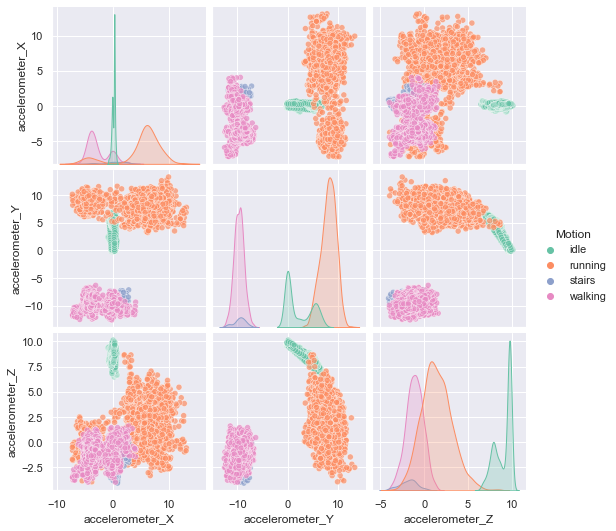

In [64]:
plt.rcParams['figure.figsize'] = (15,7)

sns.pairplot(hue='Motion', data=df_avg, plot_kws={'alpha':0.7})

plt.show()

In X, all classes, except stairs, appear to be distributed in two peaks (more distant for Running, and closer together for Idle). In Y and in Z, Idle again as a bimodal distribution, while the remaining are more normal.

We can identify Idle two completely separate macro clusters: Idle+Running and Stairs+Walking. In the case of Idle and Running, they overlap in some instances, but overall, they are easy to distinguish. On the other hand, Stairs and Walking seem to merge in all instances.

### Data Preparation

In [23]:
# Idle
s = idle.groupby(['Record','Motion']).cumcount()  
mod_idle = idle.drop('Step', axis=1).set_index(['Record','Motion', s]).unstack().sort_index(level=1, axis=1)
mod_idle.columns = [f'{x}{y}' for x, y in mod_idle.columns]
mod_idle = mod_idle.reset_index()

# Running
s = running.groupby(['Record','Motion']).cumcount()  
mod_running = running.drop('Step', axis=1).set_index(['Record','Motion', s]).unstack().sort_index(level=1, axis=1)
mod_running.columns = [f'{x}{y}' for x, y in mod_running.columns]
mod_running = mod_running.reset_index()

# Stairs
s = stairs.groupby(['Record','Motion']).cumcount()  
mod_stairs = stairs.drop('Step', axis=1).set_index(['Record','Motion', s]).unstack().sort_index(level=1, axis=1)
mod_stairs.columns = [f'{x}{y}' for x, y in mod_stairs.columns]
mod_stairs = mod_stairs.reset_index()

# Walking
s = walking.groupby(['Record','Motion']).cumcount()  
mod_walking = walking.drop('Step', axis=1).set_index(['Record','Motion', s]).unstack().sort_index(level=1, axis=1)
mod_walking.columns = [f'{x}{y}' for x, y in mod_walking.columns]
mod_walking = mod_walking.reset_index()

In [24]:
# Concatenate
df = pd.concat([mod_idle, mod_running, mod_stairs, mod_walking]) 
df.head()

,Record,Motion,accelerometer_X0,accelerometer_Y0,accelerometer_Z0,accelerometer_X1,accelerometer_Y1,accelerometer_Z1,accelerometer_X2,accelerometer_Y2,...,accelerometer_Z26,accelerometer_X27,accelerometer_Y27,accelerometer_Z27,accelerometer_X28,accelerometer_Y28,accelerometer_Z28,accelerometer_X29,accelerometer_Y29,accelerometer_Z29
0,1,idle,1.000776,4.616021,8.576031,0.718261,4.209007,8.446744,-0.909797,-0.282516,...,9.801862,-0.124498,-0.114922,9.758766,-0.167594,-0.124498,9.667787,-0.119710,-0.124498,9.792285
1,2,idle,-0.909797,-0.282516,9.203311,5.099650,0.148441,8.418014,1.762132,-0.162806,...,9.667787,-0.119710,-0.124498,9.792285,-0.100556,-0.148441,9.792285,-0.138864,-0.110133,9.782708
2,3,idle,1.762132,-0.162806,9.251195,-0.086191,-0.148441,9.787497,-0.062249,-0.191536,...,9.792285,-0.138864,-0.110133,9.782708,-0.114922,-0.129287,9.777920,-0.129287,-0.124498,9.782708
3,4,idle,-0.062249,-0.191536,9.773131,-0.057461,-0.114922,9.763555,-0.124498,-0.162806,...,9.777920,-0.129287,-0.124498,9.782708,-0.138864,-0.138864,9.777920,-0.114922,-0.119710,9.777920
4,5,idle,-0.124498,-0.162806,9.782708,-0.138864,-0.124498,9.768343,-0.095768,-0.129287,...,9.777920,-0.114922,-0.119710,9.777920,-0.114922,-0.143652,9.758766,0.014365,-0.057461,9.734824


In [25]:
# Dependent and Independent Variables
X = df.iloc[:,2:]
y = df.iloc[:,1]

With dimensionality reduction to 2D with PCA, we are able to view our clusters.

In [27]:
# Dimensionality Reduction
model_pca = PCA(n_components=2)
model_pca.fit(X)
X_2d = model_pca.transform(X)
df['PCA1'] = X_2d[:,0]
df['PCA2'] = X_2d[:,1]

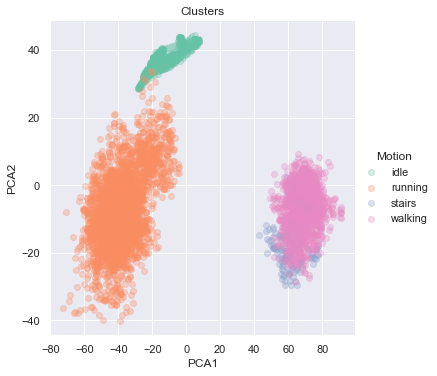

In [60]:
plt.rcParams['figure.figsize'] = (15,7)

sns.lmplot(x="PCA1", y="PCA2", hue='Motion', data=df, fit_reg=False, scatter_kws={'alpha':0.3})
plt.title('Clusters')

plt.show()

It allows to draw the same conclusions as above (the plot is similar to ZxY rotated), but simplifying our multidimensional data.

### Modelling

We will know train our models.

In the paper, SVM model provided the best results, so we will use the same here.

In [65]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

#### SVM - Support Vector Machine

SVM is a supervised ML model that uses classification algorithms ('Kernels', below) for two-class problems. We are working with four classes, so we will use One-Against-One (OAO) approach, where each class is compared against each of the others.

Our baseline model uses a Linear Kernel (equivalent to a Logistic Regression problem).

In [66]:
# Train model with Linear Kernel
linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(X_train, y_train)
linear_pred = linear.predict(X_test)

In [67]:
# Compute Accuracy of Linear Model
accuracy_lin = linear.score(X_test, y_test)
print("Accuracy of Linear Kernel:", accuracy_lin)

Accuracy of Linear Kernel: 0.9669932955131512


In [68]:
# Create Confusion Matrix
cm_lin = confusion_matrix(y_test, linear_pred)

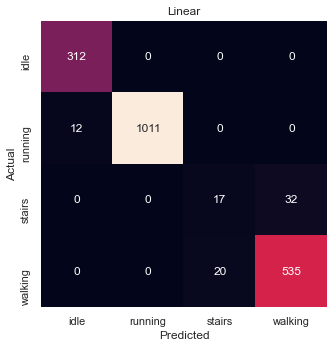

In [69]:
plt.rcParams['figure.figsize'] = (10,5)

labels = ['idle', 'running', 'stairs', 'walking']

sns.heatmap(cm_lin, xticklabels=labels, yticklabels=labels, annot=True, cbar = False, square=True,  fmt='g')
plt.title('Linear')
plt.ylabel('Actual')
plt.xlabel('Predicted')
    
plt.tight_layout()
plt.show()

Overall, our model scored 97% in accuracy.

As expected, both Idle and Running classes are easier to classify (100% for Idle and 99% for Running), and Walking was correctly classified 96% of times. Stairs, however, was only correctly identified 35% of times. This result is not surprising after analysing the plots above.

We will now explore the use of different kernels, to define our decision boundary, and to try to improve our results. We will use Polynomial kernel of 3rd degree, Radial Basis kernel and Sigmoid kernel.

In [70]:
# Train model with different Kernels
poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo').fit(X_train, y_train)
rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(X_train, y_train)
sig = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovo').fit(X_train, y_train)

In [71]:
# Make Predictions
poly_pred = poly.predict(X_test)
rbf_pred = rbf.predict(X_test)
sig_pred = sig.predict(X_test)

In [72]:
# Compute Accuracy of Kernels
accuracy_poly = poly.score(X_test, y_test)
accuracy_rbf = rbf.score(X_test, y_test)
accuracy_sig = sig.score(X_test, y_test)
print("Accuracy of Polynomial Kernel:", accuracy_poly)
print("Accuracy of Radial Basis Kernel:", accuracy_rbf)
print("Accuracy of Sigmoid Kernel:", accuracy_sig)

Accuracy of Polynomial Kernel: 0.9721505930892212
Accuracy of Radial Basis Kernel: 0.593604951005673
Accuracy of Sigmoid Kernel: 0.9731820526044352


In [73]:
# Create Confusion Matrices
cm_poly = confusion_matrix(y_test, poly_pred)
cm_rbf = confusion_matrix(y_test, rbf_pred)
cm_sig = confusion_matrix(y_test, sig_pred)

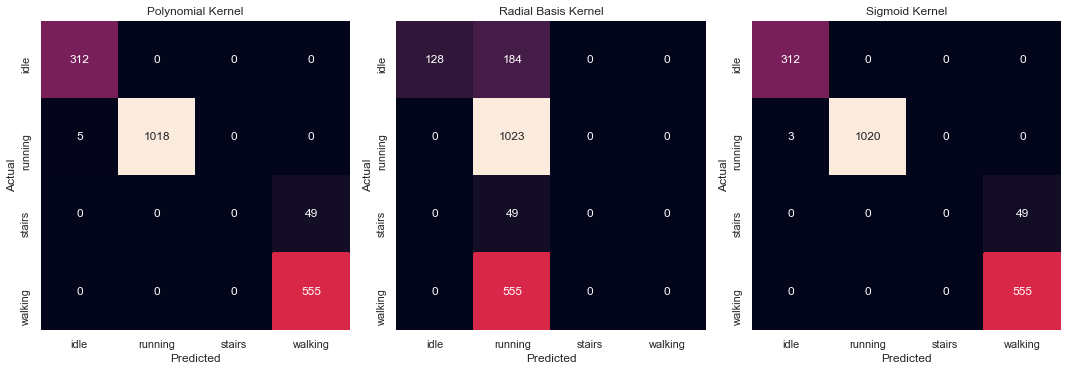

In [74]:
# Plot Confusion Matrices
plt.rcParams['figure.figsize'] = (15,7)

labels = ['idle', 'running', 'stairs', 'walking']
cms = [cm_poly, cm_rbf, cm_sig]
kernels = ['Polynomial Kernel', 'Radial Basis Kernel', 'Sigmoid Kernel']

i = 1

for cm in cms: 
    plt.subplot(1, 3, i)
    sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, cbar = False, square=True,  fmt='g')
    plt.title(kernels[i-1])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    
    i+=1

plt.tight_layout()
plt.show()

Our accuracy scores improved with the Polynomial kernel (97.2%) and the Sigmoid kernel (97.3%), and decreased significantly with Radial Basis kernel (59%).

However, while our accuracy increased with the first two kernels, it came at the cost of one class (Stairs), meaning that none of these models would perform well in the real world, as they would ignore the Stairs class. This is because, in our training and test sets, we have so few examples of Stairs records.

So, in reality, the best kernel to use in this case, and given the data that we have, is the Linear one.